# **Homework 7:** Optimization and Normalization

### Collaborators

Please list anyone you discussed or collaborated on this assignment with below.|

James duffy
G Hope

### Course feedback

Please submit this week's course survey here: https://forms.gle/aHnv3ZxmgYFV7cjD7

# Part 0: Enviornment Setup

For this homework and for the final project, you may find it useful to run your code with access to a sufficient GPU, which may allow your code to run faster (we will talk about why later in the course). If you do not have access to a powerful GPU on your personal computer (e.g. if you primarily use a laptop), then there are 2 options you may consider for using a remotely hosted GPU.

*Note that some laptops may actually run this code faster than the course server, so you may want to try it first on your laptop regardless*

In [ ]:
# This is the path that the dataset for this homework will be downloaded to.
# If you are running on the course server or Colab you can keep this line, if you are
# running on a personal computer, you may want to change this location.
data_path = '/cs/cs152/data'

## Option 1: Use the course GPU server



We have a GPU server available for this course that you all should have access to. (If you are not a Mudd student we may need to get you setup with a Mudd CS account). The server name is `teapot.cs.hmc.edu`.

You can login to the server via a terminal using your hmc username and password:

`ssh <USERNAME>@teapot.ssh.hmc.edu`

Then run the command:

`source /cs/cs152/venv/bin/activate`

to activate the course Python enviornment, followed by:

`jupyter lab --no-browser`

to start a Jupyter server (if you want to keep a server running you can use [tmux](https://www.redhat.com/sysadmin/introduction-tmux-linux)). At the end of the Jupyter startup output you should see a line like this:

![image.png](attachment:image.png)

This tells us the port and password we need to access the server remotely. In order to access the server we'll start an ssh tunnel. Open a new terminal window and run the command:

`ssh -L 9000:localhost:<PORT> <USERNAME>@teapot.cs.hmc.edu`

Where `<PORT>` is the port output from JupyterLab above (`8888` in the example image). `9000` is a local network port for your compute to access the server. If `9000` is in use, you can change the number to something different. Once the ssh tunnel is running you can access the notebook server by navigating to `http://localhost:9000/lab` in a web browser.

You can also setup VSCode to connect to this server. At the top right of the window click the kernel menu:

![image-2.png](attachment:image-2.png)

You should see the following popup:

![image-3.png](attachment:image-3.png)

Click `Select another kernel`, then `Existing Jupyter Server` and paste the address from above:

![image-6.png](attachment:image-6.png)
![image-5.png](attachment:image-5.png)

Paste the token from the Jupyter output when prompted for a password. If given multiple kernel options, select `Python3`. You should now be running the notebook code remotely!

## Option 2: Google Colab



If you are unable to get the course server to work, another option is to use Google's Colab service which provides a simple way to run GPU-accelerated Jupyter notebooks on the web.

To start, go to: `https://colab.research.google.com/`

![image.png](attachment:image.png)

Upload this notebook by either going to the upload tab on the welcome screen or selecting `file->upload notebook` in the top menu.

Once you open the notebook, you'll want to add a GPU. To do this navigate to `runtime->change runtime type` in the top menu.

![image-2.png](attachment:image-2.png)

In the popup menu select `T4 GPU` and click save.

![image-3.png](attachment:image-3.png)

Now you should be able to run the notebook! Once you've completed the assignment, you can download the notebook to submit it as usual.

# Part 1: Support Code

**There are no problems in this section, but you should read and try to understand the code being shown. Make sure to run all the cells in this section as well.**

## Set Hyperparameters

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchsummary import summary

from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, Normalize, ToTensor

from fastprogress.fastprogress import master_bar, progress_bar

import matplotlib.pyplot as plt

In [ ]:
# Use the GPUs if they are available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using '{device}' device.")

# Model hyperparameters
neurons_per_hidden_layer = [20] * 2 #two hidden layers with 20 neurons each

# Mini-Batch SGD hyperparameters
batch_size = 256
num_epochs = 10
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

Using 'cpu' device.


## Prepare the Dataset

In [ ]:
def get_fmnist_data_loaders(path, batch_size, valid_batch_size=0):
    # Computing normalization constants for Fashion-MNIST (commented out since we only need to do this once)
    # train_loader, valid_loader = get_fmnist_data_loaders(data_path, 0)
    # X, _ = next(iter(train_loader))
    # s, m = torch.std_mean(X)


    # Data specific transforms
    data_mean = (0.2860,)
    data_std = (0.3530,)
    xforms = Compose([ToTensor(), Normalize(data_mean, data_std)])

    # Training data loader
    train_dataset = FashionMNIST(root=path, train=True, download=True, transform=xforms)

    # Set the batch size to N if batch_size is 0
    tbs = len(train_dataset) if batch_size == 0 else batch_size
    train_loader = DataLoader(train_dataset, batch_size=tbs, shuffle=True)

    # Validation data loader
    valid_dataset = FashionMNIST(root=path, train=False, download=True, transform=xforms)

    # Set the batch size to N if batch_size is 0
    vbs = len(valid_dataset) if valid_batch_size == 0 else valid_batch_size
    valid_loader = DataLoader(valid_dataset, batch_size=vbs, shuffle=True)

    return train_loader, valid_loader

In [ ]:
# Load the example dataset (Fashion MNIST)
train_loader, valid_loader = get_fmnist_data_loaders(data_path, batch_size)

print("Training dataset shape   :", train_loader.dataset.data.shape)
print("Validation dataset shape :", valid_loader.dataset.data.shape)

Training dataset shape   : torch.Size([60000, 28, 28])
Validation dataset shape : torch.Size([10000, 28, 28])


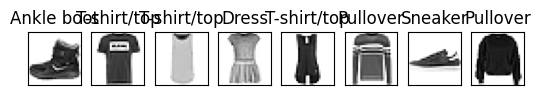

In [ ]:
# Let's plot a few images as an example
num_to_show = 8
images = train_loader.dataset.data[:num_to_show]
targets = train_loader.dataset.targets[:num_to_show]
labels = [train_loader.dataset.classes[t] for t in targets]

fig, axes = plt.subplots(1, num_to_show)

for axis, image, label in zip(axes, images, labels):
    axis.imshow(image.squeeze(), cmap="Greys")
    axis.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_title(f"{label}")

## Create a Neural Network

In [ ]:
class Layer(nn.Module):
    # This class will represent a basic neural network layer with a linear function
    # and an activation (in this case ReLU)
    def __init__(self, in_dimensions, out_dimensions):
        super().__init__()
        self.linear = nn.Linear(in_dimensions, out_dimensions)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.linear(x)
        x = self.activation(x)
        return x

class NeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, layer_class=Layer):
        super(NeuralNetwork, self).__init__()

        # The first "layer" just rearranges the Nx28x28 input into Nx784
        first_layer = nn.Flatten()

        # The hidden layers include:
        # 1. a linear component (computing Z) and
        # 2. a non-linear comonent (computing A)
        hidden_layers = [
            (layer_class(nlminus1, nl) if nlminus1 == nl else Layer(nlminus1, nl))
            for nl, nlminus1 in zip(layer_sizes[1:-1], layer_sizes)
        ]

        # The output layer must be Linear without an activation. See:
        #   https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
        output_layer = nn.Linear(layer_sizes[-2], layer_sizes[-1])

        # Group all layers into the sequential container
        all_layers = [first_layer] + hidden_layers + [output_layer]
        self.layers = nn.Sequential(*all_layers)

    def forward(self, X):
        return self.layers(X)

## Implement an Optimizer

In [ ]:
class SGDOptimizer:
    def __init__(self, parameters, lr=0.01):
        # Set the learning rate
        self.lr = lr
        # Store the set of parameters that we'll be optimizing
        self.parameters = list(parameters)

    def step(self):
        # Take a step of gradient descent
        for ind, parameter in enumerate(self.parameters):
            # Compute the update to the parameter
            update = self.lr * parameter.grad

            # Update the parameter: w <- w - lr * grad
            parameter -= update

## Train Classifier

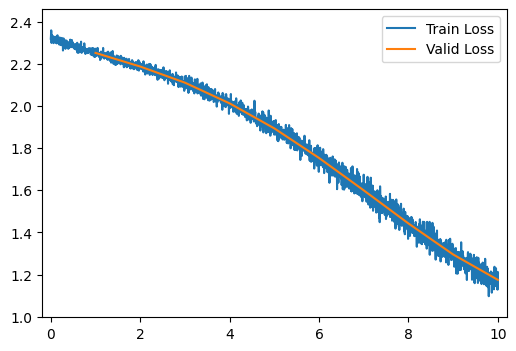

[10/10] Train Loss = 1.2289; Valid Loss = 1.1747; Valid Accuracy = 66.5%


In [ ]:
# Here we'll define a function to train and evaluate a neural network with a specified architecture
# using a specified optimizer.
def run_model(optimizer=SGDOptimizer,
              layer_type=Layer,
              number_of_hidden_layers=2,
              neurons_per_hidden_layer=20,
              learning_rate=0.001):

    # Get the dataset
    train_loader, valid_loader = get_fmnist_data_loaders(data_path, batch_size)

    # The input layer size depends on the dataset
    nx = train_loader.dataset.data.shape[1:].numel()

    # The output layer size depends on the dataset
    ny = len(train_loader.dataset.classes)

    # Preprend the input and append the output layer sizes
    layer_sizes = [nx] + [neurons_per_hidden_layer] * number_of_hidden_layers + [ny]

    # Do model creation here so that the model is recreated each time the cell is run
    model = NeuralNetwork(layer_sizes, layer_type).to(device)

    t = 0
    # Create the optimizer, just like we have with the built-in optimizer
    opt = optimizer(model.parameters(), learning_rate)

    # A master bar for fancy output progress
    mb = master_bar(range(num_epochs))

    # Information for plots
    mb.names = ["Train Loss", "Valid Loss"]
    train_losses = []
    valid_losses = []

    for epoch in mb:

        #
        # Training
        #
        model.train()

        train_N = len(train_loader.dataset)
        num_train_batches = len(train_loader)
        train_dataiterator = iter(train_loader)

        train_loss_mean = 0

        for batch in progress_bar(range(num_train_batches), parent=mb):

            # Grab the batch of data and send it to the correct device
            train_X, train_Y = next(train_dataiterator)
            train_X, train_Y = train_X.to(device), train_Y.to(device)

            # Compute the output
            train_output = model(train_X)

            # Compute loss
            train_loss = criterion(train_output, train_Y)

            num_in_batch = len(train_X)
            tloss = train_loss.item() * num_in_batch / train_N
            train_loss_mean += tloss
            train_losses.append(train_loss.item())

            # Compute gradient
            model.zero_grad()
            train_loss.backward()

            # Take a step of gradient descent
            t += 1
            with torch.no_grad():
                opt.step()

        #
        # Validation
        #
        model.eval()

        valid_N = len(valid_loader.dataset)
        num_valid_batches = len(valid_loader)

        valid_loss_mean = 0
        valid_correct = 0

        with torch.no_grad():

            # valid_loader is probably just one large batch, so not using progress bar
            for valid_X, valid_Y in valid_loader:

                valid_X, valid_Y = valid_X.to(device), valid_Y.to(device)

                valid_output = model(valid_X)

                valid_loss = criterion(valid_output, valid_Y)

                num_in_batch = len(valid_X)
                vloss = valid_loss.item() * num_in_batch / valid_N
                valid_loss_mean += vloss
                valid_losses.append(valid_loss.item())

                # Convert network output into predictions (one-hot -> number)
                predictions = valid_output.argmax(1)

                # Sum up total number that were correct
                valid_correct += (predictions == valid_Y).type(torch.float).sum().item()

        valid_accuracy = 100 * (valid_correct / valid_N)

        # Report information
        tloss = f"Train Loss = {train_loss_mean:.4f}"
        vloss = f"Valid Loss = {valid_loss_mean:.4f}"
        vaccu = f"Valid Accuracy = {(valid_accuracy):>0.1f}%"
        mb.write(f"[{epoch+1:>2}/{num_epochs}] {tloss}; {vloss}; {vaccu}")

        # Update plot data
        max_loss = max(max(train_losses), max(valid_losses))
        min_loss = min(min(train_losses), min(valid_losses))

        x_margin = 0.2
        x_bounds = [0 - x_margin, num_epochs + x_margin]

        y_margin = 0.1
        y_bounds = [min_loss - y_margin, max_loss + y_margin]

        valid_Xaxis = torch.linspace(0, epoch + 1, len(train_losses))
        valid_xaxis = torch.linspace(1, epoch + 1, len(valid_losses))
        graph_data = [[valid_Xaxis, train_losses], [valid_xaxis, valid_losses]]

        mb.update_graph(graph_data, x_bounds, y_bounds)

    print(f"[{epoch+1:>2}/{num_epochs}] {tloss}; {vloss}; {vaccu}")

run_model()

# Part 2: Optimizers

In this part, we'll implement and test some of the optimizers that we learned about in class.

#### **Q1**

Let's start with the *momentum optimizer*. Recall that the update equations for stochastic gradient descent with momentum can be written as follows:

$$ \mathbf{v}^{(k+1)} \longleftarrow \beta \mathbf{v}^{(k)} + (1-\beta) \nabla_{\mathbf{w}} \textbf{Loss}(\mathbf{w}^{(k)}, \mathbf{x}_i, y_i)$$
$$ \mathbf{w}^{(k+1)} \longleftarrow \mathbf{w}^{(k)} - \alpha v^{(k+1)}$$

Refer to the SGDOptimizer implementation above to understand how our optimizer works. At a high level our optimizer class will:
- Maintain a list of the parameters of a model.
- Provide a `step()` method to update the parameters according to the update equations.

As we saw last time, we assume that the optimizer is *not* responsible for computing gradients. When step is called, we assume each parameter knows the gradient of the loss with respect to itself. This value is stored in `parameter.grad`.

Fill in the implementation of `MomentumOptimizer` below, according to the update equations above.

In [ ]:
class MomentumOptimizer(SGDOptimizer):
    # Gradient descent with momentum
    def __init__(self, parameters, lr=0.01, mu=0.9):
        # Set the learning rate
        self.lr = lr
        # Set the momentum update rate
        self.mu = mu
        # Store the set of parameters that we'll be optimizing
        self.parameters = list(parameters)
        # Store the velocity for each parameter
        self.velocity = [torch.zeros_like(param) for param in self.parameters]

    def step(self):
        # Take a step of gradient descent
        for ind, parameter in enumerate(self.parameters):
            # First update the velocity
            self.velocity[ind] = self.mu * self.velocity[ind] + (1 - self.mu) * parameter.grad #or should it use the lr in place of (1 - self.mu)?

            # Then compute the update to the parameter
            update = self.lr * self.velocity[ind]

            # Finally update the parameter as before
            parameter -= update

#### **Q2**
Train and evaluate the model using the `MomentumOptimizer` by running the cell below. Do the results seem different from the `SGDOptimizer`? Why do you think this might be?

The results look almost the exact same to me, as supported by their very similar traning/valifation loss and accuracy. This is surprising since MomentumOptimier introduces momentum into the optimization process, which I expected to accelerate convergence anf thereby lower to Training/validation loss much quicker. However, if the dataset and the model are not very complex, the benefits of using momentum in optimization may not be enough to cause noticeable differences in performance.

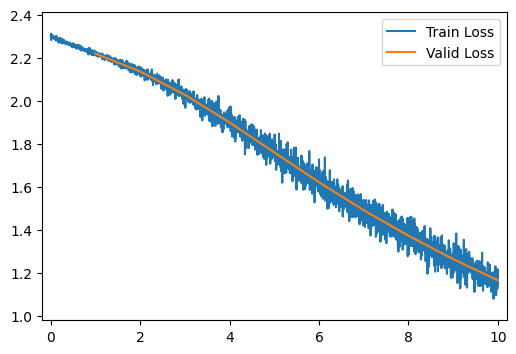

[10/10] Train Loss = 1.2082; Valid Loss = 1.1649; Valid Accuracy = 60.2%


In [ ]:
run_model(optimizer=MomentumOptimizer)

#### **Q3**

Now let's try the *RMSProp optimizer*. Recall that the update equations for RMSProp can be written as follows:

$$ \mathbf{s}^{(k+1)} \longleftarrow \beta \mathbf{s}^{(k)} + (1-\beta) (\nabla_{\mathbf{w}} \textbf{Loss}(\mathbf{w}^{(k)}, \mathbf{X}, \mathbf{y}))^2$$
$$ \mathbf{w}^{(k+1)} \longleftarrow \mathbf{w}^{(k)} - \alpha \frac{\nabla_{\mathbf{w}} \textbf{Loss}(\mathbf{w}^{(k)}, \mathbf{X}, \mathbf{y})}{\sqrt{\mathbf{s}^{(k+1)} + \epsilon}}$$


Fill in the implementation of `RMSPropOptimizer` below, according to the update equations above.

In [ ]:
epsilon = 1e-7
class RMSPropOptimizer(SGDOptimizer):
    # RMSProp Optimizer
    def __init__(self, parameters, lr=0.01, beta=0.9):
        # Set the learning rate
        self.lr = lr
        # Set the scale update rate
        self.beta = beta
        # Store the set of parameters that we'll be optimizing
        self.parameters = list(parameters)

        # Store any values that you'll need for RMSProp here
        self.scale = [torch.zeros_like(param) for param in self.parameters]

    def step(self):
        # Take a step of gradient descent
        for ind, parameter in enumerate(self.parameters):
            # First compute any updates needed for RMSProp here
            self.scale[ind] = self.beta * self.scale[ind] + (1 - self.beta) * (parameter.grad ** 2)

            # Then compute the update to the parameter
            update = (self.lr * parameter.grad) / (torch.sqrt(self.scale[ind]) + epsilon)


            # Finally update the parameter as before
            parameter -= update

#### **Q4**
Train and evaluate the model using the `RMSPropOptimizer` by running the cell below. Do the results seem different from the `SGDOptimizer`? Why do you think this might be?

There is a drastic difference in model performancen between these two optimizers. The RMSPropOptimizer has losses which decrease very quickly, whereas the SGDoptimizer has a more gradual decline which requires many more steps. Additionally, the RMSPropOptimizer has a training/validation loss of 0.34 and 0.39 respectivly, which are much lower than SGDOptimizer (1.22 and 1.17 respectivly). RMSPropOptimizers accuracy of 86.0% is 29.3% bigger than SGDoptimizer's 66.5%. This is most likely a result of the fact that MSPropOptimizer adjusts the learning rate for each parameter based on the magnitude of the gradients observed in previous iterations meaning the learning rate is more adaptive which will improve convergence speed and stability.

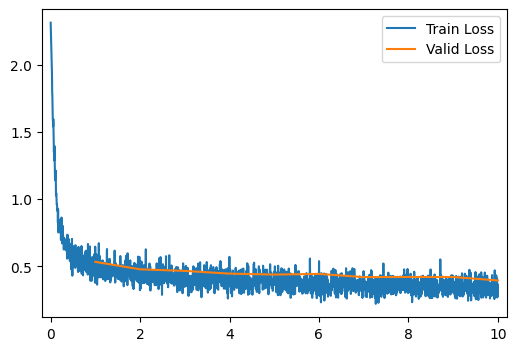

[10/10] Train Loss = 0.3435; Valid Loss = 0.3951; Valid Accuracy = 86.0%


In [ ]:
run_model(optimizer=RMSPropOptimizer)

#### **Q5**

Finally let's try the *Adam optimizer*. Recall that the update equations for Adam can be written as follows:

$$ \mathbf{v}^{(k+1)} \longleftarrow \beta_1 \mathbf{v}^{(k)} + (1-\beta_1) \nabla_{\mathbf{w}} \textbf{Loss}(\mathbf{w}^{(k)}, \mathbf{X}, \mathbf{y})$$
$$ \mathbf{s}^{(k+1)} \longleftarrow \beta_2 \mathbf{s}^{(k)} + (1-\beta_2) (\nabla_{\mathbf{w}} \textbf{Loss}(\mathbf{w}^{(k)}, \mathbf{X}, \mathbf{y}))^2$$
$$ \mathbf{w}^{(k+1)} \longleftarrow \mathbf{w}^{(k)} - \alpha \frac{\frac{\mathbf{v}^{(k+1)}}{(1-\beta_1^k)}
}{\sqrt{\frac{\mathbf{s}^{(k+1)}}{(1-\beta_2^k)} + \epsilon}}$$


Fill in the implementation of `AdamOptimizer` below, according to the update equations above.

In [ ]:
epsilon = 1e-7
class AdamOptimizer(SGDOptimizer):
    # Adam optimizer
    def __init__(self, parameters, lr=0.01, beta1=0.9, beta2=0.99):
        # Set the learning rate
        self.lr = lr
        # Set the scale update rate
        self.beta1 = beta1
        self.beta2 = beta2

        # Store the set of parameters that we'll be optimizing
        self.parameters = list(parameters)
        # Store any values that you'll need for Adam here
        self.adamupdate1 = [torch.zeros_like(param) for param in self.parameters]
        self.adamupdate2 = [torch.zeros_like(param) for param in self.parameters]

    def step(self):
        # Take a step of gradient descent
        for ind, parameter in enumerate(self.parameters):
            # First compute any updates needed for Adam here
            self.adamupdate1[ind] = self.beta1 * self.adamupdate1[ind] + (1 - self.beta1) * parameter.grad
            self.adamupdate2[ind] = self.beta2 * self.adamupdate2[ind] + (1 - self.beta2) * (parameter.grad ** 2)

            adamupdate1_corrected = self.adamupdate1[ind] / (1 - self.beta1)
            adamupdate2_corrected = self.adamupdate2[ind] / (1 - self.beta2)

            # Then compute the update to the parameter
            update = self.lr * (adamupdate1_corrected / (torch.sqrt(adamupdate2_corrected) + epsilon))

            # Finally update the parameter as before
            parameter -= update

#### **Q6**
Train and evaluate the model using the `AdamOptimizer` by running the cell below. Do the results seem different from the `SGDOptimizer`? Why do you think this might be?

Similar to question 4, the AdamOptimizer has losses which decrease very quickly, whereas the SGDoptimizer has a more gradual decline which requires many more steps. the AdamOptimizer has respective training/validation losses of 0.33 and 0.39 respectivly, which are much lower than SGDOptimizer (1.22 and 1.17 respectivly). Additionally, the AdamOptimizer has an accuracy of 85.7% is 28.87% bigger than SGDoptimizer's 66.5%. This makes sense as Adam combines the concepts of momentum and RMSProp by aintaining exponentially decaying averages of past gradients and squared gradients. This allows for faster convergence and better handling of sparse gradients which explains the improvment in loss

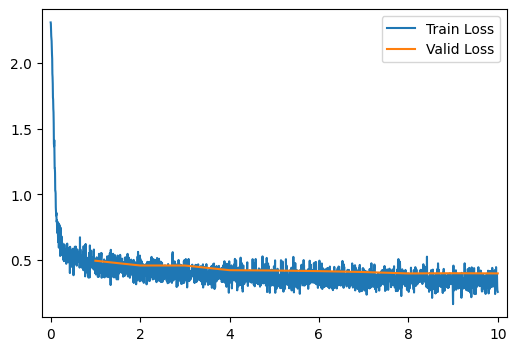

[10/10] Train Loss = 0.3406; Valid Loss = 0.4002; Valid Accuracy = 86.1%


In [ ]:
run_model(optimizer=AdamOptimizer)

# Part 3: Normalization and Residual Networks

#### **Q7**

Try training a 20 layer network by running the cell below. What do you notice happening? Why does this happen?

the train and validation loss are compeletey flat. This may be a result of vanishing/exploding gradients which can make it difficult for the optimizer to update the parameters and can lead to the network being stuck in a local minimum or failing to learn meaningful representations


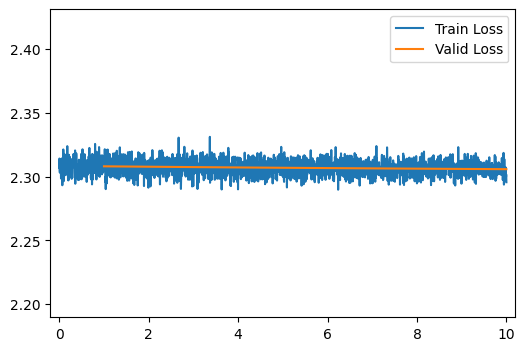

[10/10] Train Loss = 2.3059; Valid Loss = 2.3058; Valid Accuracy = 10.0%


In [ ]:
run_model(number_of_hidden_layers=20)

#### **Q8**

Let's try applying normalization, starting with *Layer Normalization*.

Assume we have a data matrix $\mathbf{X} \in \mathbb{R}^{N \times d}$, (i.e. $\mathbf{X}$ is an $N \times d$ matrix), such that:
$$N:\ \text{Number of observations}$$
$$d:\ \text{Number of features}$$
Then we can define layer normalization as a function that normalizes the *rows* of this matrix. We can define this function element-wise as:
$$\text{LayerNorm}(\mathbf{X})_{ij} = \frac{\mathbf{X}_{ij} - \mathbf{\bar{x}}_i}{\sqrt{\mathbf{s}^2_{i} + \epsilon}}$$
$$\mathbf{\bar{x}}_i = \frac{1}{d} \sum_{k=1}^d \mathbf{X}_{ik}, \quad \mathbf{s}^2_{i} = \frac{1}{d-1}\sum_{k=1}^d \big( \mathbf{X}_{ik} - \mathbf{\bar{x}}_i \big)^2$$

Complete the implementation of Layer Normalization below:

In [ ]:
epsilon = 1e-7
class LayerNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # Compute mean and variance along the feature dimension (across all column values of row i in X)
        mean = x.mean(dim=-1, keepdim=True)
        variance = x.var(dim=-1, unbiased=False, keepdim=True)
        x_normalized = (x - mean) / torch.sqrt(variance + epsilon)
        return x_normalized

# Replace our Layer class with one that includes layer normalization
class LayerNormLayer(nn.Module):
    def __init__(self, in_dimensions, out_dimensions):
        super().__init__()
        self.linear = nn.Linear(in_dimensions, out_dimensions)
        self.layer_norm = LayerNorm()
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.linear(x)
        x = self.layer_norm(x)
        x = self.activation(x)
        return x

#### **Q9**

Train and evaluate a 20-layer network with layer normalization by running the cell below. What changed from the run without layer normalization? Why?

There is actually a decrease in loss here - since each layer's input is normalized, the vanishing or exploding gradients problem is reduced.

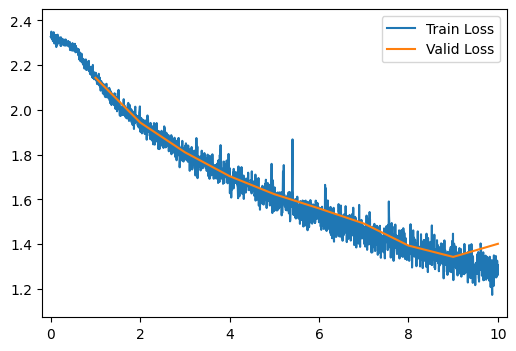

[10/10] Train Loss = 1.3042; Valid Loss = 1.4012; Valid Accuracy = 58.5%


In [ ]:
run_model(number_of_hidden_layers=20, layer_type=LayerNormLayer)

#### **Q10**

Now let's try a *Batch Normalization*.

Assume we have the same data matrix $\mathbf{X} \in \mathbb{R}^{N \times d}$ described above.

We can define batch normalization as a function that normalizes the *columns* of this matrix. We can define this function element-wise as:
$$\text{BatchNorm}(\mathbf{X})_{ij} = \frac{\mathbf{X}_{ij} - \mathbf{\bar{x}}_j}{\sqrt{\mathbf{s}^2_{j} + \epsilon}}$$
$$\mathbf{\bar{x}}_j = \frac{1}{d} \sum_{k=1}^d \mathbf{X}_{kj}, \quad \mathbf{s}^2_{j} = \frac{1}{d-1}\sum_{k=1}^d \big( \mathbf{X}_{kj} - \mathbf{\bar{x}}_j \big)^2$$
Recall that at *training time* we will also update running estimates of the batch mean and variance:
$$\mathbf{\bar{\mu}}_j^{(k+1)} \longleftarrow \beta \mathbf{\bar{\mu}}^{(k)}_j + (1-\beta) \mathbf{\bar{x}}_j$$
$$\mathbf{\bar{\sigma}}_j^{2(k+1)} \longleftarrow \beta \mathbf{\bar{\sigma}}^{2(k)}_j + (1-\beta) \mathbf{\bar{s}}^2_j$$
At *test/evaluation* time we will use these estimates:
$$\underset{\text{Test}}{\text{BatchNorm}}(\mathbf{X})_{ij} = \frac{\mathbf{X}_{ij} - \mathbf{\bar{x}}_j}{\sqrt{\mathbf{s}^2_{j} + \epsilon}}$$

Complete the implementation of Batch Normalization below:

In [ ]:
epsilon = 1e-7
class BatchNorm(nn.Module):
    def __init__(self, dimensions, beta=0.9):
        super().__init__()
        self.beta=beta
        self.running_mean = torch.zeros((1, dimensions))
        self.running_var = torch.ones((1, dimensions))

    def forward(self, x):
        # Needed for GPU compatibility
        self.running_mean = self.running_mean.to(x.device)
        self.running_var = self.running_var.to(x.device)

        if self.training:
            mean = x.mean(dim=0, keepdim=True)
            variance = x.var(dim=0, unbiased=False, keepdim=True)
            self.running_mean = self.beta * self.running_mean + (1 - self.beta) * mean
            self.running_var = self.beta * self.running_var + (1 - self.beta) * variance
            x_normalized = (x - mean) / torch.sqrt(variance + epsilon)
        else:
            x_normalized = (x - self.running_mean) / torch.sqrt(self.running_var + epsilon)

        return x_normalized

class BatchNormLayer(nn.Module):
    def __init__(self, in_dimensions, out_dimensions):
        super().__init__()
        self.linear = nn.Linear(in_dimensions, out_dimensions)
        self.layer_norm = BatchNorm(out_dimensions)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.linear(x)
        x = self.layer_norm(x)
        x = self.activation(x)
        return x

#### **Q11**

Train and evaluate a 20-layer network with batch normalization by running the cell below. What changed from the run without normalization? Why?

There is a smooth decline in both kinds of loss indicating better convergence and training stability. Batch normalization helps stabilize the training process by reducing internal covariate shift which probably lead to our smoother convergence and faster training.

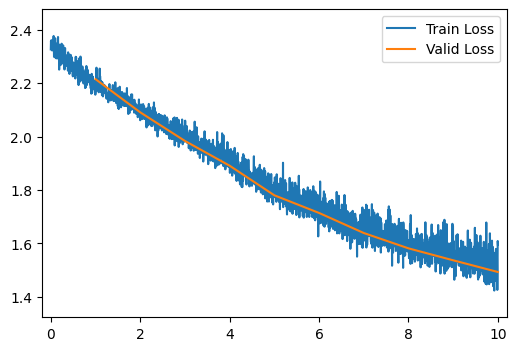

[10/10] Train Loss = 1.5323; Valid Loss = 1.4927; Valid Accuracy = 53.6%


In [ ]:
run_model(number_of_hidden_layers=20, layer_type=BatchNormLayer)

#### **Q12**

Finally, let's try a residual network!

Recall that a standard neural network layer with a `ReLU` activation can be written as:

$$\phi(\mathbf{X}) = \text{ReLU}(\mathbf{X}\mathbf{W}^T + \mathbf{b})$$

A *residual layer* in contrast can be written as:
$$\phi_{res}(\mathbf{X}) = \text{ReLU}(\mathbf{X}\mathbf{W}^T + \mathbf{b}) + \mathbf{X}$$

Complete the residual layer implementation below. You may assume that the input and output size of this layer are the same.

In [ ]:
class ResidualLayer(nn.Module):
    def __init__(self, dimensions, *args):
        super().__init__()
        self.linear = nn.Linear(dimensions, dimensions)
        self.activation = nn.ReLU()

    def forward(self, x):
        residual = x
        x = self.linear(x)
        x = self.activation(residual)
        x = x + residual
        return x

#### **Q13**

Try running a residual network using the cell below. How did this network perform? Why?

In [ ]:
run_model(number_of_hidden_layers=20, layer_type=ResidualLayer)

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'